# **CIND 820**
## **German Credit Classification**



In [66]:
# Required Python Libraries

# Google Colab file importing
from google.colab import files

# basic data manipulation
import pandas as pd
import numpy as np

# data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# time
import time

# scikit-learn preprocessing
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.base import is_classifier

from sklearn.inspection import permutation_importance
from sklearn.feature_selection import RFE
import statsmodels.api as sm

# Imbalanced-Learn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.over_sampling import ADASYN

# scikit-learn models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

# XGBoost model
from xgboost import XGBClassifier

# scikit-learn model evauluation metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

# model explainability
import shap

# **Pipelines**

### **Loading German Credit Pipeline**

Upload to Google Colab the German Credit Data dataset from local file 'german.data' and apply  preproccessing for baseline comparison

**_load_GermanCredit_pipeline()_**

>_load_GermanCredit()_ : loads German Credit to pandas DataFrame from local file.

>_encode_categorical()_ : encodes nominal and ordinal features in German Credit DataFrame

>_convert_to_binary()_ : converts 'Target' column to binary (0 = good, 1 = bad)

>_split_data()_ : splits into training and testing sets

In [67]:
def load_GermanCredit():
  """
  Load German Credit dataset from a local file to a pandas dataframe.

  Args:
    None

  Returns:
    df: pandas dataframe containing the preprocessed German Credit dataset
  """

  # data upload to Gogle Colab from local stroage
  uploaded = files.upload()

  # # define German Credit column names per documentation
  column_names = [
    "Status of Existing Account", "Duration", "Credit History", "Purpose",
    "Credit Amount", "Savings Account", "Employment Tenure", "Utilization",
    "Relationship Status", "Other Debtors", "Residence Tenure", "Property",
    "Age", "Outisde Credit", "Housing", "Credit Products",
    "Job", "Responsibility", "Telephone", "Foreign Worker", "Target"
  ]

  # read German Credit data into DataFrame with Pandas python library
  # no header row on the original data file
  df = pd.read_csv('german.data', sep=' ', header=None, names=column_names)

  # update data types on German Credit (numeric to object)
  # change the 'Utilization' column to type object
  df['Utilization'] = df['Utilization'].astype(str)
  # change the 'Residence Tenure' column to type object
  df['Residence Tenure'] = df['Residence Tenure'].astype(str)
  # change the 'Responsibility' column to type object
  df['Responsibility'] = df['Responsibility'].astype(str)

  return df

In [68]:
def encode_categorical(df):
  """
  Encode categorical variables in a pandas dataframe.
  Args:
    df: pandas dataframe containing dataset.
    ordinal_variables: dictionary of ordinal variables.
  Returns:
    df: pandas dataframe with categorical variables encoded
  """

  # make a copy of the original DF to ensure data integrity
  encoded_df = df.copy()

  print(encoded_df['Utilization'].unique())
  print(encoded_df['Utilization'].apply(type).unique())

  # orderinal variables
  ordinal_variables = {
    'Status of Existing Account': ['A11', 'A12', 'A13', 'A14'],
    'Credit History': ['A30', 'A31', 'A32', 'A33', 'A34'],
    'Savings Account': ['A61', 'A62', 'A63', 'A64', 'A65'],
    'Employment Tenure': ['A71', 'A72', 'A73', 'A74', 'A75'],
    'Utilization': ['1', '2', '3', '4'],
    'Residence Tenure': ['1', '2', '3', '4']
  }

  # filtering for categorical date type columns (object or category)
  categorical_columns = df.select_dtypes(include=['object', 'category']).columns

  # separate nominal and ordinal columns
  ordinal_columns = list(ordinal_variables.keys())
  nominal_columns = [col for col in categorical_columns if col not in ordinal_columns]

  print(nominal_columns)
  print(ordinal_columns)

  # apply one-hot encoding if nominal variables exist
  if nominal_columns:
        encoded_df = pd.get_dummies(encoded_df, columns=nominal_columns, drop_first=True)

  # apply ordinal encoding if ordinal variables exist
  if ordinal_columns:
        # all ordinal columns exist in the DataFrame
        valid_ordinal_columns = [col for col in ordinal_columns if col in encoded_df.columns]
        if valid_ordinal_columns:
            # get category orders for ordinal columns
            ordinal_categories = [ordinal_variables[col] for col in valid_ordinal_columns]
            # initialize OrdinalEncoder with category orders
            encoder = OrdinalEncoder(categories=ordinal_categories, dtype=int)
            # apply encoding to ordinal columns
            encoded_df[valid_ordinal_columns] = encoder.fit_transform(encoded_df[valid_ordinal_columns])

  return encoded_df

In [69]:
def convert_to_binary(df):
  """
  Converts a categorical target variable in a pandas DataFrame to binary values.

  Args:
    df: A pandas DataFrame containing dataset with target variable.

  Returns:
    A new pandas DataFrame with the target variable converted to binary values.

  Raises:
    ValueError: If column contains values other than 1 or 2
    ValueError: If target column not found in DataFrame
  """

  # initialize target column
  target_column = 'Target'

  # check target column exists
  if target_column not in df.columns:
    raise ValueError(f"Target column '{target_column}' not found in DataFrame.")

  # validate target variable 1 or 2
  if not df[target_column].isin([1, 2]).all():
    raise ValueError(f"Target column '{target_column}' contains values other than 1 or 2.")

  # convert target variable to binary with map
  df[target_column] = df[target_column].map({1: 0, 2: 1})

  return df

In [70]:
def split_data(df):
  """
  Split a pandas dataframe into training and testing sets.
  """

  # drop target column
  features = df.drop('Target', axis=1)

  # select target column
  target = df['Target']

  features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.2, random_state=42)

  return features_train, features_test, target_train, target_test

In [71]:
def load_GermanCredit_pipeline():
  """
  Loads German Credit dataset from a local file to a pandas dataframe, encodes categrical variables, convert target to binary, and splits data into training and testing sets.

  Args:
    none

  Returns:
    features_train: training features
    features_test: testing features
    target_train: training target
    target_test: testing target
  """

  # load German Credit dataset to reference dataframe
  df = load_GermanCredit()

  # encode categorical variables
  df = encode_categorical(df)

  # convery target variable to binary
  df = convert_to_binary(df)

  # split data into training and testing sets
  features_train, features_test, target_train, target_test = split_data(df)

  return features_train, features_test, target_train, target_test

### **Classification Model Comparison Pipeline**

Train, test, and evaluate classification models on the German Credit dataset under stages of parameter tuning and data optimization

Note: _display_cm()_ could be considered a visual extension of _display_core_metrics()_

Classification Models:
* Logistic Regression
* Decision Tree
* K Nearest-Neighbors
* Support Vector Machine
* XGBoost

Metrics:
* accuracy
* precision
* recall
* F1
* specificity

Plots:
* Confusion Matrix
* ROC AUC

**_classification_comp_pipeline()_**

> **_train_models()_**
>>_base_models()_ : classification without model hyperparameter tuning using imbalanced not scaled data
>>_scaled_models()_ : classification imbalanced data without hyperparameter tuning but scaling applied
>>_scaled_bal_models()_ : classification on scaled balanced without hyperparameter tuning

>**_display_core_metrics()_**
>>_core_metrics()_ : compute accuracy, precision, recall, F1, and specificity
>> _wall_time()_ : access model training times
>>_compute_core_metrics()_ : compute core metrics for each model group

>**_display_cm_()**

>**_display_roc()_**
>>_compute_roc()_ : plot ROC for group/stage of classification models


In [72]:
def base_models(features_train, features_test, target_train, target_test):
  """
  Train and make predictions with base classification models without any hyperparameter tuning using a dataset that is imblanced and not scaled.

  Args:
    features_train: training features
    features_test: testing features
    target_train: training target
    target_test: testing target

  Returns:
    dictionary of models with predictions and probability
  """

  # list of models
  model_funcs = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC()),
    ('XGBoost', XGBClassifier())
  ]

  # initialize dictionary
  models = {}

  # loop through all models for predictions and probabilities
  for model_name, model_func in model_funcs:
    # start time
    start_wall = time.perf_counter()
    # initialize model
    model = model_func
    # train model
    model.fit(features_train, target_train)
    # end time
    end_wall = time.perf_counter()
    # calculate wall time to train model
    wall_time = end_wall - start_wall
    # make predictions
    predictions = model.predict(features_test)
    # probability for ROC AUC (SVM decision_function all others predict_proba)
    if model_name == 'SVM':
      probabilities = model.decision_function(features_test)
    else:
      probabilities = model.predict_proba(features_test)[:, 1]
    # update dictionary
    models[model_name] = {
      'predictions': predictions,
      'probabilities': probabilities,
      'Wall Clock Time': wall_time
    }

  return models

In [73]:
def scaled_models(features_train, features_test, target_train, target_test):
  """
  Train and make predictions with classification models using a scaled but imbalanced dataset without any hyperparameter tuning.
  Args:
    features_train: training features
    features_test: testing features
    target_train: training target
    target_test: testing target

  Returns:
    dictionary of models with predictions and probability
  """

  # numerical columns
  numerical_columns = [
      'Duration',
      'Credit Amount',
      'Age',
      'Credit Products'
  ]

  # initialize scaler
  scaler = StandardScaler()

  # apply scaler to numerical columns
  # fit on the training data
  features_train[numerical_columns] = scaler.fit_transform(features_train[numerical_columns])
  # transform the test data using the same scaler (avoids leakage)
  features_test[numerical_columns] = scaler.transform(features_test[numerical_columns])

  # list of models
  model_funcs = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC()),
    ('XGBoost', XGBClassifier())
  ]

  # initialize dictionary
  num_scaled_models = {}

  # loop through all models for predictions and probabilities
  for model_name, model_func in model_funcs:
    # start time
    start_wall = time.perf_counter()
    # initialize model
    model = model_func
    # train model
    model.fit(features_train, target_train)
    # end time
    end_wall = time.perf_counter()
    # calculate wall time to train model
    wall_time = end_wall - start_wall
    # make predictions
    predictions = model.predict(features_test)
    # probability for ROC AUC (SVM decision_function all others predict_proba)
    if model_name == 'SVM':
      probabilities = model.decision_function(features_test)
    else:
      probabilities = model.predict_proba(features_test)[:, 1]
    # update dictionary
    num_scaled_models[model_name] = {
      'predictions': predictions,
      'probabilities': probabilities,
      'Wall Clock Time': wall_time
    }

  return num_scaled_models

In [74]:
def scaled_bal_models(features_train, features_test, target_train, target_test):
  """
  Train and make predictions with classification models using a balanced abd scaled dataset without any hyperparameter tuning.
  Args:
    features_train: training features
    features_test: testing features
    target_train: training target
    target_test: testing target

  Returns:
    dictionary of models with predictions and probability
  """

  # numerical columns
  numerical_columns = [
      'Duration',
      'Credit Amount',
      'Age',
      'Credit Products'
  ]

  # initialize scaler
  scaler = StandardScaler()

  # apply scaler to numerical columns
  # fit on the training data
  features_train[numerical_columns] = scaler.fit_transform(features_train[numerical_columns])
  # transform the test data using the same scaler (avoids leakage)
  features_test[numerical_columns] = scaler.transform(features_test[numerical_columns])

  # apply SMOTE to balance the dataset
  smote = SMOTE(random_state=42)
  features_train, target_train = smote.fit_resample(features_train, target_train)

  # list of models
  model_funcs = [
    ('Logistic Regression', LogisticRegression()),
    ('Decision Tree', DecisionTreeClassifier()),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC()),
    ('XGBoost', XGBClassifier())
  ]

  # initialize dictionary
  num_scaled_bal_models = {}

  # loop through all models for predictions and probabilities
  for model_name, model_func in model_funcs:
    # start time
    start_wall = time.perf_counter()
    # initialize model
    model = model_func
    # train model
    model.fit(features_train, target_train)
    # end time
    end_wall = time.perf_counter()
    # calculate wall time to train model
    wall_time = end_wall - start_wall
    # make predictions
    predictions = model.predict(features_test)
    # probability for ROC AUC (SVM decision_function all others predict_proba)
    if model_name == 'SVM':
      probabilities = model.decision_function(features_test)
    else:
      probabilities = model.predict_proba(features_test)[:, 1]
    # update dictionary
    num_scaled_bal_models[model_name] = {
      'predictions': predictions,
      'probabilities': probabilities,
      'Wall Clock Time': wall_time
    }

  return num_scaled_bal_models

In [75]:
def tuned_scaled_bal_models(features_train, features_test, target_train, target_test):
    """
    Train and make predictions with tuned classification models using a balanced and scaled dataset with hyperparameter tuning via GridSearchCV.

    Args:
        features_train: training features
        features_test: testing features
        target_train: training target
        target_test: testing target

    Returns:
        dictionary of tuned models with predictions and probabilities
    """

    # Numerical columns to scale (same as before)
    numerical_columns = [
        'Duration',
        'Credit Amount',
        'Age',
        'Credit Products'
    ]

    # Initialize scaler
    scaler = StandardScaler()

    # Apply scaler to numerical columns
    features_train[numerical_columns] = scaler.fit_transform(features_train[numerical_columns])
    features_test[numerical_columns] = scaler.transform(features_test[numerical_columns])

    # Apply SMOTE to balance the dataset
    smote = SMOTE(random_state=42)
    features_train, target_train = smote.fit_resample(features_train, target_train)

    # Define models with their parameter grids
    model_configs = [
        ('Logistic Regression', LogisticRegression(), {
            'C': [0.01, 0.1, 1, 10, 100],
            'solver': ['liblinear', 'lbfgs']
        }),
        ('Decision Tree', DecisionTreeClassifier(), {
            'max_depth': [None, 5, 10, 15, 20],
            'min_samples_split': [2, 5, 10]
        }),
        ('KNN', KNeighborsClassifier(), {
            'n_neighbors': [3, 5, 7, 9],
            'weights': ['uniform', 'distance']
        }),
        ('SVM', SVC(probability=True), {  # probability=True for predict_proba
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }),
        ('XGBoost', XGBClassifier(), {
            'learning_rate': [0.01, 0.1, 0.3],
            'max_depth': [3, 5, 7],
            'n_estimators': [50, 100, 200]
        })
    ]

    # Initialize dictionary
    tuned_models = {}

    # Loop through models, tune, and predict
    for model_name, model_func, param_grid in model_configs:
        # Start time
        start_wall = time.perf_counter()

        # Initialize GridSearchCV (5-fold CV, optimize for F1 since imbalanced data)
        grid_search = GridSearchCV(estimator=model_func, param_grid=param_grid, cv=5, scoring='f1', n_jobs=-1)

        # Fit on training data
        grid_search.fit(features_train, target_train)

        # Get the best model
        best_model = grid_search.best_estimator_

        # End time
        end_wall = time.perf_counter()
        wall_time = end_wall - start_wall

        # Make predictions
        predictions = best_model.predict(features_test)

        # Probabilities for ROC AUC
        if model_name == 'SVM':
            probabilities = best_model.decision_function(features_test)
        else:
            probabilities = best_model.predict_proba(features_test)[:, 1]

        # Update dictionary (include best params for reference)
        tuned_models[model_name] = {
            'predictions': predictions,
            'probabilities': probabilities,
            'Wall Clock Time': wall_time,
            'best_params': grid_search.best_params_
        }

    return tuned_models

In [76]:
def train_test_model(features_train, features_test, target_train, target_test):
  """
  Train and make predictions with classification models under various stages of parameter tuning and data optimization.
  Args:
    features_train: training features
    features_test: testing features
    target_train: training target
    target_test: testing target

  Returns:
    base: dictionary of models with predictions and probability
    num_scaled: dictionary of number scaled models with predictions and probability
    num_scaled_bal: dictionary of number scaled and balanced models with predictions and probability
  """

  # train and test base models
  base = base_models(features_train, features_test, target_train, target_test)

  # train and test scaled models
  num_scaled = scaled_models(features_train, features_test, target_train, target_test)

  # train and test scaled balanced models
  num_scaled_bal = scaled_bal_models(features_train, features_test, target_train, target_test)

  # train and test scaled balanced tuned models
  tuned = tuned_scaled_bal_models(features_train, features_test, target_train, target_test)

  return base, num_scaled, num_scaled_bal, tuned

In [77]:
def core_metrics(models, target_test):
  """
  Compute accuracy, precision, recall, F1, and specificity for each model group.

  Args:
    models: dictionary of models with predictions and probabilities.

  Return:
    Dictionary of metrics for each model group.
  """

  # initialize dictionary to store model scores
  scores = {}

  for model_name, model_data in models.items():
    predictions = model_data['predictions']

    # compute accuracy
    accuracy = accuracy_score(target_test, predictions)

    # compute precision
    precision = precision_score(target_test, predictions)

    # compute recall
    recall = recall_score(target_test, predictions)

    # compute F1 score
    f1 = f1_score(target_test, predictions)

    # compute specificity
    tn, fp, fn, tp = confusion_matrix(target_test, predictions).ravel()
    specificity = tn / (tn + fp)

    # update dictionary
    scores[model_name] = {
      'accuracy': accuracy,
      'precision': precision,
      'recall': recall,
      'f1': f1,
      'specificity': specificity
    }

  return scores

In [78]:
def wall_time_display(base, num_scaled, num_scaled_bal, tuned):
  """
  Display wall clock time for each model group.
  Args:
    base: dictionary of models with predictions and probabilities.
    num_scaled: dictionary of number scaled models with predictions and probability
    num_scaled_bal: dictionary of number scaled and balanced models with predictions and probability

  Return:
    None
  """
  # base model training time
  print("\n Base Models:\n")
  for model_name, model_data in base.items():
    print(f"{model_name} Wall Clock Time: {model_data['Wall Clock Time']:.4f} seconds")

  # number scaled model training time
  print("\n Number Scaled Models:\n")
  for model_name, model_data in num_scaled.items():
    print(f"{model_name} Wall Clock Time: {model_data['Wall Clock Time']:.4f} seconds")

  # number scaled and balanced training time
  print("\n Number Scaled Balanced Models:\n")
  for model_name, model_data in num_scaled_bal.items():
    print(f"{model_name} Wall Clock Time: {model_data['Wall Clock Time']:.4f} seconds")

  # tuned training time
  print("\n Tuned Models:\n")
  for model_name, model_data in tuned.items():
    print(f"{model_name} Wall Clock Time: {model_data['Wall Clock Time']:.4f} seconds")

In [79]:
def compute_core_metrics(base, num_scaled, num_scaled_bal, tuned, target_test):
  """
  Compute core metrics for each model group.

  Args:
    base: dictionary of models with predictions and probabilities.
    num_scaled: dictionary of number scaled models with predictions and probability
    num_scaled_bal: dictionary of number scaled and balanced models with predictions and probability
    target_test: testing target

  Return:
    Dictionary of metrics for each model group.
  """

  # compute base core metrics
  base_metrics = core_metrics(base, target_test)

  # compute scaled core metrics
  num_scaled_metrics = core_metrics(num_scaled, target_test)

  # compute scaled balanced core metrics
  num_scaled_bal_metrics = core_metrics(num_scaled_bal, target_test)

  # compute scaled balanced tuned core metrics
  tuned_metrics = core_metrics(tuned, target_test)

  return base_metrics, num_scaled_metrics, num_scaled_bal_metrics, tuned_metrics

In [80]:
def display_core_metrics(base, num_scaled, num_scaled_bal, tuned, target_test):
  """
  Display core metrics for each model group.

  Args:
    base: dictionary of models with predictions and probabilities.
    num_scaled: dictionary of number scaled models with predictions and probability
    num_scaled_bal: dictionary of number scaled and balanced models with predictions and probability

  Return:
    None
  """

  # compute metrics
  base_metrics, num_scaled_metrics, num_scaled_bal_metrics, tuned_metrics= compute_core_metrics(base, num_scaled, num_scaled_bal, tuned, target_test)

  # pandas df for base metrics
  metrics_df = pd.DataFrame(base_metrics)
  metrics_df = metrics_df.transpose()

  # display base model metrics
  print("\nBase Models:\n")
  print(metrics_df)

  # pandas df for number scaled model metrics
  num_scaled_df = pd.DataFrame(num_scaled_metrics)
  num_scaled_df = num_scaled_df.transpose()

  # display number scaled model metrics
  print("\nNumber Scaled Models:\n")
  print(num_scaled_df)

  # pandas df for balanced number scaled metrics
  num_scaled_bal_df = pd.DataFrame(num_scaled_bal_metrics)
  num_scaled_bal_df = num_scaled_bal_df.transpose()

  # display balanced number scaled model metrics
  print("\nBalanced Number Scaled Models:\n")
  print(num_scaled_bal_df)

  # pandas df for tuned model metrics
  tuned_df = pd.DataFrame(tuned_metrics)
  tuned_df = tuned_df.transpose()

  # display tuned model metrics
  print("\nTuned Models:\n")
  print(tuned_df)


In [81]:
def display_cm(base, num_scaled, num_scaled_bal, tuned, target_test):
    """
    Plots confusion matrices for each model side by side in a single figure per model.

    Args:
        base: Dictionary of base models with predictions.
        num_scaled: Dictionary of scaled models with predictions.
        num_scaled_bal: Dictionary of scaled and balanced models with predictions.
        target_test: True target values for testing.

    Returns:
        None (displays plots)
    """
    # List of model names (assuming all dictionaries have the same keys)
    model_names = list(base.keys())

    for model_name in model_names:
        # Get predictions for each version
        pred_base = base[model_name]['predictions']
        pred_scaled = num_scaled[model_name]['predictions']
        pred_scaled_bal = num_scaled_bal[model_name]['predictions']
        pred_tuned = tuned[model_name]['predictions']

        # Compute confusion matrices
        cm_base = confusion_matrix(target_test, pred_base)
        cm_scaled = confusion_matrix(target_test, pred_scaled)
        cm_scaled_bal = confusion_matrix(target_test, pred_scaled_bal)
        cm_tuned = confusion_matrix(target_test, pred_tuned)

        # Create figure with 4 subplots side by side
        fig, axes = plt.subplots(2, 2, figsize=(10, 10))
        fig.suptitle(f'Confusion Matrices for {model_name}')

        # Plot base CM
        sns.heatmap(cm_base, annot=True, fmt='d', cmap='Blues', ax=axes[0, 0],
                    xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
        axes[0,0].set_title('Base')
        axes[0,0].set_xlabel('Predicted')
        axes[0,0].set_ylabel('Actual')

        # Plot scaled CM
        sns.heatmap(cm_scaled, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
                    xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
        axes[0,1].set_title('Scaled')
        axes[0,1].set_xlabel('Predicted')
        axes[0,1].set_ylabel('Actual')

        # Plot scaled & balanced CM
        sns.heatmap(cm_scaled_bal, annot=True, fmt='d', cmap='Blues', ax=axes[1,0],xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
        axes[1,0].set_title('Scaled & Balanced')
        axes[1,0].set_xlabel('Predicted')
        axes[1,0].set_ylabel('Actual')

        # pl0t tuned cm
        sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues', ax=axes[1,1],xticklabels=['Good', 'Bad'], yticklabels=['Good', 'Bad'])
        axes[1,1].set_title('Tuned')
        axes[1,1].set_xlabel('Predicted')
        axes[1,1].set_ylabel('Actual')

        plt.tight_layout()
        plt.show()

In [82]:
def plot_roc_auc(models, target_test):
  """
  Plot ROC AUC for model group.

  Args:
    models: dictionary of models with predictions and probabilities.
    target_test: testing target

  Return:
    None
  """

  # initialize plot
  plt.figure(figsize=(10, 6))
  auc_scores = {}

  for model_name, model_data in models.items():
    # model probabilities
    probabilities = model_data['probabilities']

    # calculate ROC AUC
    fpr, tpr, thresholds = roc_curve(target_test, probabilities)
    roc_auc = auc(fpr, tpr)
    auc_scores[model_name] = roc_auc

    # plot ROC curve
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')

  # plot diagonal line (randome classifier)
  plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')

  # set labels and title
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic (ROC) Curve')
  plt.legend()
  plt.grid(True)

  # show plot
  plt.show()

In [83]:
def display_roc_auc(base, num_scaled, num_scaled_bal, tuned, target_test):
  """
  Display ROC AUC for all model groups.

  Args:
    base: dictionary of models with predictions and probabilities.
    num_scaled: dictionary of number scaled models with predictions and probability
    num_scaled_bal: dictionary of number scaled and balanced models with predictions and probability
    target_test: testing target

  Return:
    None
  """

  # base model ROC AUC
  print("\n")
  print("Base Models:\n")
  plot_roc_auc(base, target_test)
  print("\n")

  # number scaled model ROC AUC
  print("Number Scaled Models:\n")
  plot_roc_auc(num_scaled, target_test)
  print("\n")

  # number scaled balanced model ROC AUC
  print("Number Scaled Balanced Models:\n")
  plot_roc_auc(num_scaled_bal, target_test)
  print("\n")

  #number scaled balanced tuned model ROC AUC
  print("Number Scaled Balanced Tuned Models:\n")
  plot_roc_auc(tuned, target_test)
  print("\n")

In [84]:
def model_comp_pipeline(features_train, features_test, target_train, target_test):
  """
  Evaluate classification models performance on various stages of data transformation and model tuning.

  Args:
    features_train: training features
    features_test: testing features
    target_train: training target
    target_test: testing target

  Returns:
    None
  """
  # train and test each model group
  base, num_scaled, num_scaled_bal, tuned = train_test_model(features_train, features_test, target_train, target_test)

  # time to train models in each group
  wall_time_display(base, num_scaled, num_scaled_bal, tuned)

  # core metrics organized by group for each model
  display_core_metrics(base, num_scaled, num_scaled_bal, tuned, target_test)

  # plot confusion matrix for each group organized by model
  display_cm(base, num_scaled, num_scaled_bal, tuned, target_test)

  # plot ROC AUC by each model group
  display_roc_auc(base, num_scaled, num_scaled_bal, tuned, target_test)

## **Feature Importance**

Reduce features using importance from Logistic Regression and test the results on XGBoost

**_feature_importance_pipeline()_**
>_feature_importance_lr()_ : 5x methods of testing feature importance on Logistic Regression model

>_plot_all_feature_importance()_ : plots bar chart to visualize Logistic Regression feature methods

>_feature_reduction_xgboost()_ : test and plots all 5x reduced Logistic Regression feature methods on XGBoost

In [96]:
def feature_importance_lr(features_train, features_test, target_train, target_test):
    """
    Pipeline to compute feature importance for Logistic Regression using multiple methods.

    Args:
        features_train: training features
        features_test: testing features
        target_train: training target
        target_test: testing target

    Returns:
        Dictionary containing feature importances from each method.
    """

    # Standardize features
    scaler = StandardScaler()
    features_train_scaled = scaler.fit_transform(features_train)
    features_test_scaled = scaler.transform(features_test)

    # Fit Logistic Regression on scaled data
    lr = LogisticRegression(max_iter=1000)
    lr.fit(features_train_scaled, target_train)

    feature_names = features_train.columns.tolist()

    results = {}

    # 1. Standardized Coefficients
    std_coefs = np.abs(lr.coef_[0])
    importance_std = dict(zip(feature_names, std_coefs))
    results['standardized_coefficients'] = sorted(importance_std.items(), key=lambda x: x[1], reverse=True)

    # 2. Odds Ratios
    odds_ratios = np.exp(lr.coef_[0])
    # For importance, use absolute log(odds ratios) to measure deviation from 1
    abs_log_or = np.abs(np.log(odds_ratios))
    importance_or = dict(zip(feature_names, abs_log_or))
    results['odds_ratios'] = sorted(importance_or.items(), key=lambda x: x[1], reverse=True)

    # 3. Feature Importance via Permutation
    perm_importance = permutation_importance(lr, features_test_scaled, target_test, n_repeats=10, random_state=42)
    importance_perm = dict(zip(feature_names, perm_importance.importances_mean))
    results['permutation_importance'] = sorted(importance_perm.items(), key=lambda x: x[1], reverse=True)

    # 4. Statistical Significance (p-values) using statsmodels
    X_train_sm = sm.add_constant(features_train_scaled)
    logit_model = sm.Logit(target_train, X_train_sm)
    result = logit_model.fit(disp=0)
    p_values = result.pvalues[1:]  # Exclude intercept
    importance_p = dict(zip(feature_names, p_values))
    results['p_values'] = sorted(importance_p.items(), key=lambda x: x[1])

    # 5. Feature Selection Methods (RFE)
    rfe = RFE(estimator=LogisticRegression(max_iter=1000), n_features_to_select=1)
    rfe.fit(features_train_scaled, target_train)
    ranking = rfe.ranking_
    importance_rfe = dict(zip(feature_names, ranking))
    results['rfe_ranking'] = sorted(importance_rfe.items(), key=lambda x: x[1])

    return results

In [97]:
def plot_all_feature_importances(results):
    """
    Plot aggregated feature importance for all methods in the results dictionary.

    Args:
      results: Dictionary from feature_importance_lr, where keys are method names and values are sorted lists of (feature, value) tuples.

    Returns:
      None
    """

    # loop all feature importance methods
    for method, importance_list in results.items():
        features, importances = zip(*importance_list)

        # Customize title and ylabel based on method
        if method == 'standardized_coefficients':
            title = 'Feature Importance: Standardized Coefficients (higher = more important)'
            ylabel = 'Absolute Standardized Coefficient'
        elif method == 'odds_ratios':
            title = 'Feature Importance: Odds Ratios (higher abs(log(OR)) = more important)'
            ylabel = 'Absolute Log(Odds Ratio)'
        elif method == 'permutation_importance':
            title = 'Feature Importance: Permutation Importance (higher drop = more important)'
            ylabel = 'Mean Decrease in Performance'
        elif method == 'p_values':
            title = 'Feature Importance: P-Values (lower = more important)'
            ylabel = 'P-Value'
        elif method == 'rfe_ranking':
            title = 'Feature Importance: RFE Ranking (lower = more important)'
            ylabel = 'Ranking'
        else:
            title = f'Feature Importance: {method.capitalize()}'
            ylabel = 'Value'

        plt.figure(figsize=(10, 6))
        plt.bar(features, importances, color='skyblue')
        plt.xlabel('Features')
        plt.ylabel(ylabel)
        plt.title(title)
        plt.xticks(rotation=45, ha='right')
        plt.tight_layout()
        plt.show()

In [101]:
def feature_reduction_xgboost(results, top_n=10, threshold=None, plot_results=True):
    """
    Function to reduce features based on logistic regression importance and evaluate XGBoost performance.

    Args:
      results: Dictionary from feature_importance_lr, where keys are method names and values are sorted lists of (feature, value) tuples.
      importance_method: Method to use for feature selection ('standardized_coefficients', 'odds_ratios', 'permutation_importance', 'p_values', 'rfe_ranking')
      top_n: Number of top features to select (if threshold is None)
      threshold: Threshold for feature selection (e.g., 0.5 for standardized_coefficients, 0.05 for p_values)

    Returns:
      Dictionary with selected features, reduced dataset performance, and comparison to baseline XGBoost.
    """

    # get importance results
    importance_results = results

    # Initialize results dictionary
    all_results = {}

    # List of importance methods to loop through
    importance_methods = ['standardized_coefficients', 'odds_ratios', 'permutation_importance', 'p_values', 'rfe_ranking']

    # Loop through each importance method
    for importance_method in importance_methods:
        print(f"\n=== Evaluating Feature Selection with {importance_method} ===")

        # Get feature importance scores
        if importance_method not in importance_results:
            print(f"Skipping {importance_method}: Not found in importance_results")
            continue

        importance_scores = importance_results[importance_method]

        # Select features
        if importance_method == 'p_values':
            # For p-values, select features below threshold or top_n with lowest p-values
            if threshold is not None:
                selected_features = [f for f, v in importance_scores if v < threshold]
            else:
                selected_features = [f for f, _ in importance_scores[:top_n]]
        elif importance_method == 'rfe_ranking':
            # For RFE, select features with lowest ranks (e.g., rank <= threshold or top_n)
            if threshold is not None:
                selected_features = [f for f, v in importance_scores if v <= threshold]
            else:
                selected_features = [f for f, _ in importance_scores[:top_n]]
        else:
            # For other methods, select features above threshold or top_n
            if threshold is not None:
                selected_features = [f for f, v in importance_scores if v > threshold]
            else:
                selected_features = [f for f, _ in importance_scores[:top_n]]

        print(f"Selected Features ({importance_method}): {selected_features}")

        # Map aggregated features back to original columns (for nominal features)
        original_columns = []
        for feature in selected_features:
            if '_' in feature and feature in features_train.columns:
                # If feature is a dummy variable, include it directly
                original_columns.append(feature)
            elif feature not in features_train.columns:
                # If feature is a base nominal feature (e.g., 'Purpose'), include all its dummy columns
                original_columns.extend([col for col in features_train.columns if col.startswith(f"{feature}_")])
            else:
                # If feature is ordinal or numeric, include it directly
                original_columns.append(feature)

        # Create reduced datasets
        features_train_reduced = features_train[original_columns]
        features_test_reduced = features_test[original_columns]

        # Train and evaluate XGBoost on reduced dataset
        start_time = time.perf_counter()
        xgb = XGBClassifier(random_state=42)
        xgb.fit(features_train_reduced, target_train)
        end_time = time.perf_counter()
        wall_time = end_time - start_time

        predictions = xgb.predict(features_test_reduced)
        probabilities = xgb.predict_proba(features_test_reduced)[:, 1]

        # Compute performance metrics
        performance = {
            'accuracy': accuracy_score(target_test, predictions),
            'precision': precision_score(target_test, predictions),
            'recall': recall_score(target_test, predictions),
            'f1_score': f1_score(target_test, predictions),
            'roc_auc': roc_auc_score(target_test, probabilities),
            'wall_time': wall_time
        }

        # Store results
        all_results[importance_method] = {
            'selected_features': selected_features,
            'original_columns': original_columns,
            'reduced_performance': performance
        }

    # Compare with baseline XGBoost (using all features)
    start_time = time.perf_counter()
    xgb_baseline = XGBClassifier(random_state=42)
    xgb_baseline.fit(features_train, target_train)
    end_time = time.perf_counter()
    baseline_wall_time = end_time - start_time

    baseline_predictions = xgb_baseline.predict(features_test)
    baseline_probabilities = xgb_baseline.predict_proba(features_test)[:, 1]

    baseline_performance = {
        'accuracy': accuracy_score(target_test, baseline_predictions),
        'precision': precision_score(target_test, baseline_predictions),
        'recall': recall_score(target_test, baseline_predictions),
        'f1_score': f1_score(target_test, baseline_predictions),
        'roc_auc': roc_auc_score(target_test, baseline_probabilities),
        'wall_time': baseline_wall_time
    }

    # Add baseline to results
    all_results['baseline'] = {'performance': baseline_performance}

    # Plot performance comparisons if requested
    if plot_results:
        metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
        for metric in metrics:
            plt.figure(figsize=(10, 6))
            method_names = [m for m in importance_methods if m in all_results]
            reduced_scores = [all_results[m]['reduced_performance'][metric] for m in method_names]
            baseline_score = baseline_performance[metric]

            plt.bar(method_names, reduced_scores, color='skyblue', label=f'Reduced Dataset ({metric})')
            plt.axhline(y=baseline_score, color='r', linestyle='--', label=f'Baseline ({metric})')
            plt.xlabel('Feature Importance Method')
            plt.ylabel(metric.capitalize())
            plt.title(f'XGBoost {metric.capitalize()} by Feature Importance Method (top_n={top_n})')
            plt.xticks(rotation=45, ha='right')
            plt.legend()
            plt.grid(True, axis='y')
            plt.tight_layout()
            plt.show()

    return all_results

In [99]:
def feature_importance_pipeline(features_train, features_test, target_train, target_test):
  """
  Pipeline to compute feature importance for Logistic Regression using multiple methods. Evaluate results on XGBoost.

  Args:
    features_train: training features
    features_test: testing features
    target_train: training target
    target_test: testing target

  Returns:
    None
  """

  # calculate Logistic Regression feature importance
  results = feature_importance_lr(features_train, features_test, target_train, target_test)

  # plot feature importance
  plot_all_feature_importances(results)

  # XGBoost using reduced features
  feature_reduction_xgboost(results)

# **Pipeline Execution**

This section, _split into three blocks_,  initiates the end-to-end analysis workflow by executing each pipeline module in the intended order. Running this section will produce the final outputs and results used for interpretation or reporting.

Execution Blocks:

   1) Load German Credit Dataset

   2) Classification Model Comparison

   3) Feature Importance

### **Load German Credit Data**

This block executes the _load_GermanCredit_pipeline()_

In [89]:
# load processed German Credit dataset
features_train, features_test, target_train, target_test = load_GermanCredit_pipeline()

Saving german.data to german (6).data
['4' '2' '3' '1']
[<class 'str'>]
['Purpose', 'Relationship Status', 'Other Debtors', 'Property', 'Outisde Credit', 'Housing', 'Job', 'Responsibility', 'Telephone', 'Foreign Worker']
['Status of Existing Account', 'Credit History', 'Savings Account', 'Employment Tenure', 'Utilization', 'Residence Tenure']


### **Classification Model Comparison**

This block executes _model_comp_pipeline()_

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



 Base Models:

Logistic Regression Wall Clock Time: 0.0286 seconds
Decision Tree Wall Clock Time: 0.0104 seconds
KNN Wall Clock Time: 0.0031 seconds
SVM Wall Clock Time: 0.0770 seconds
XGBoost Wall Clock Time: 0.0727 seconds

 Number Scaled Models:

Logistic Regression Wall Clock Time: 0.0266 seconds
Decision Tree Wall Clock Time: 0.0103 seconds
KNN Wall Clock Time: 0.0033 seconds
SVM Wall Clock Time: 0.0383 seconds
XGBoost Wall Clock Time: 0.0792 seconds

 Number Scaled Balanced Models:

Logistic Regression Wall Clock Time: 0.0178 seconds
Decision Tree Wall Clock Time: 0.0149 seconds
KNN Wall Clock Time: 0.0047 seconds
SVM Wall Clock Time: 0.0713 seconds
XGBoost Wall Clock Time: 0.1225 seconds

 Tuned Models:

Logistic Regression Wall Clock Time: 3.1523 seconds
Decision Tree Wall Clock Time: 1.1245 seconds
KNN Wall Clock Time: 0.5590 seconds
SVM Wall Clock Time: 21.8541 seconds
XGBoost Wall Clock Time: 13.8622 seconds

Base Models:

                     accuracy  precision    recall 

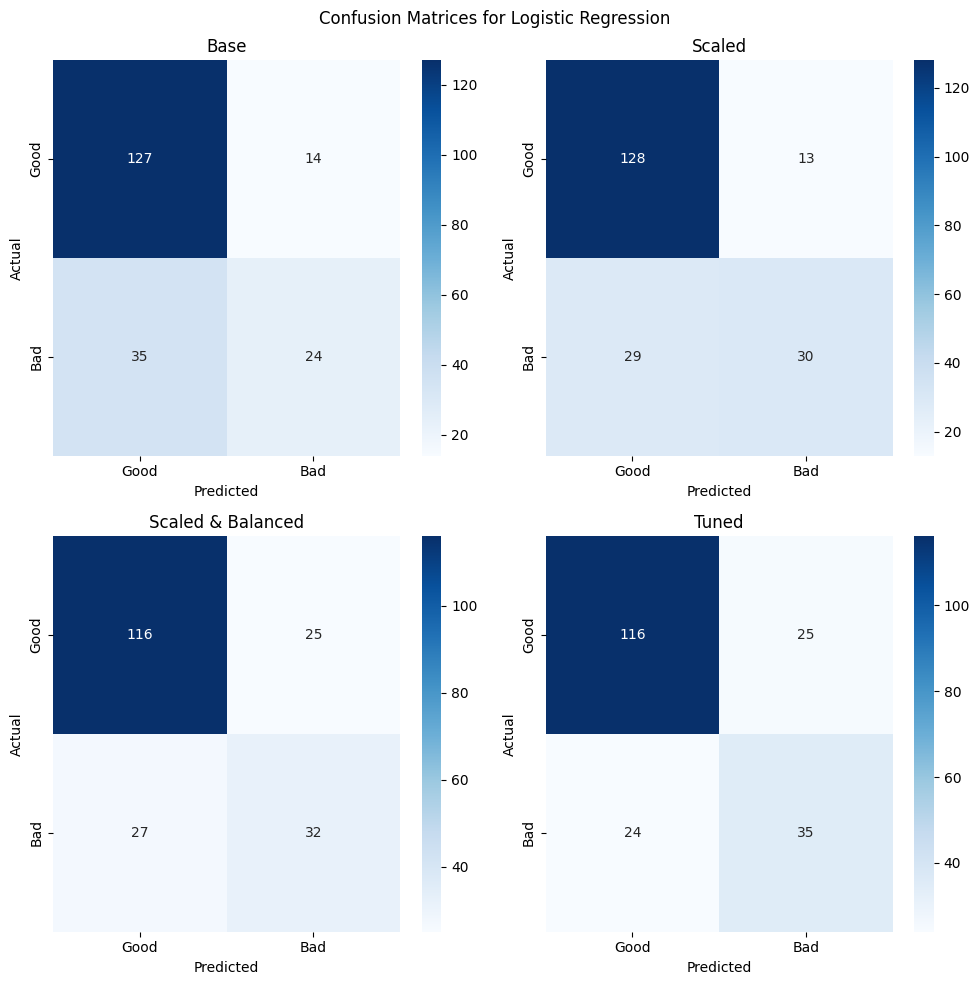

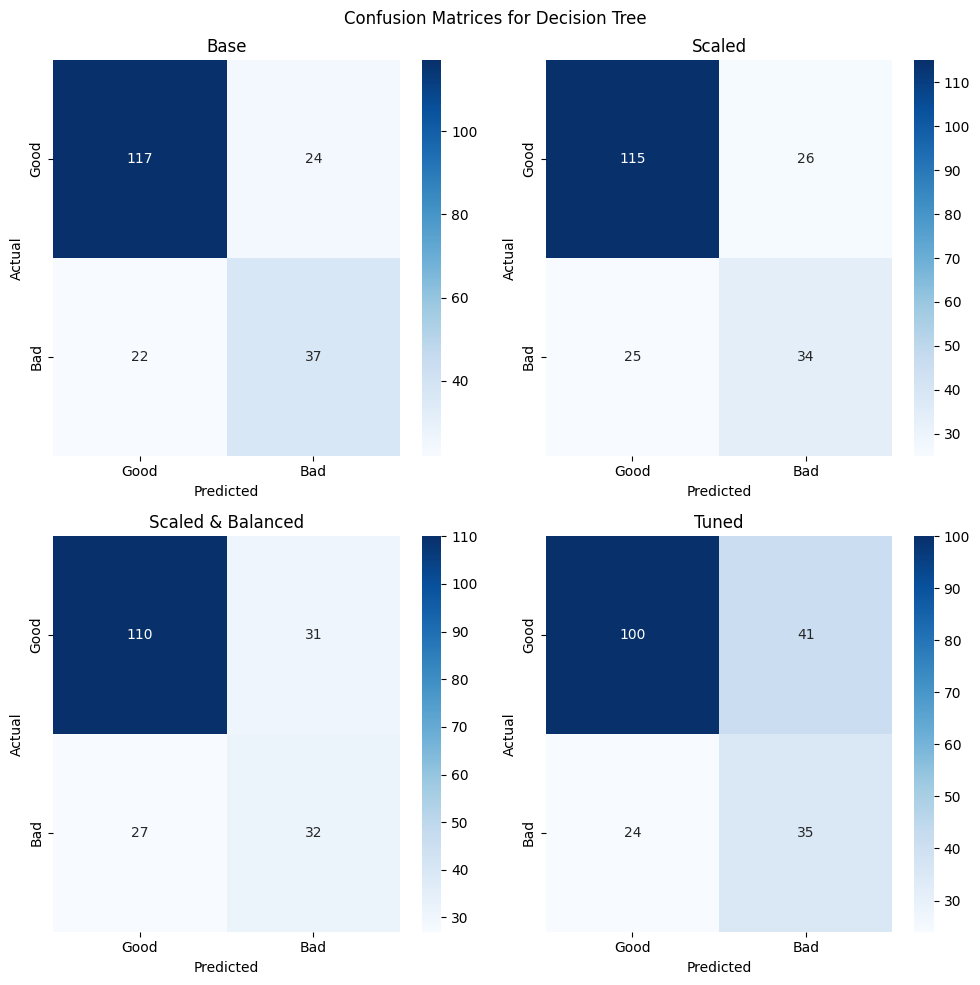

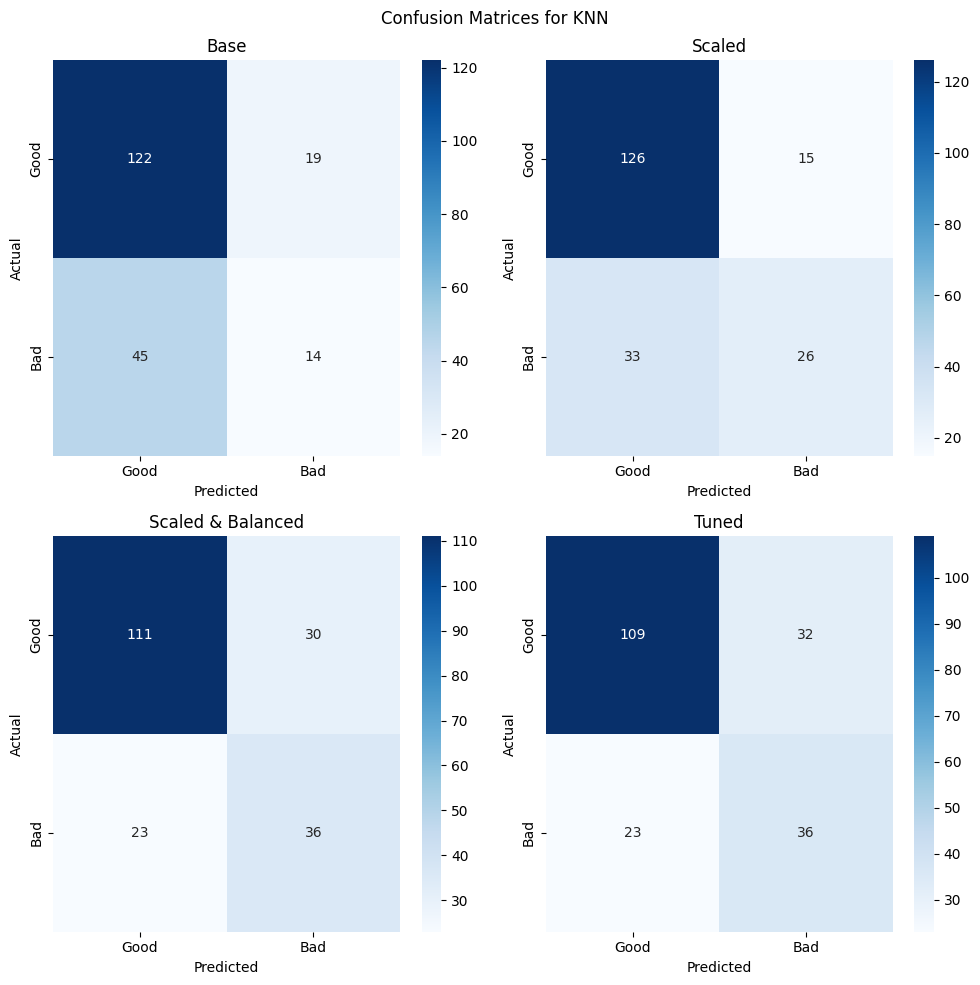

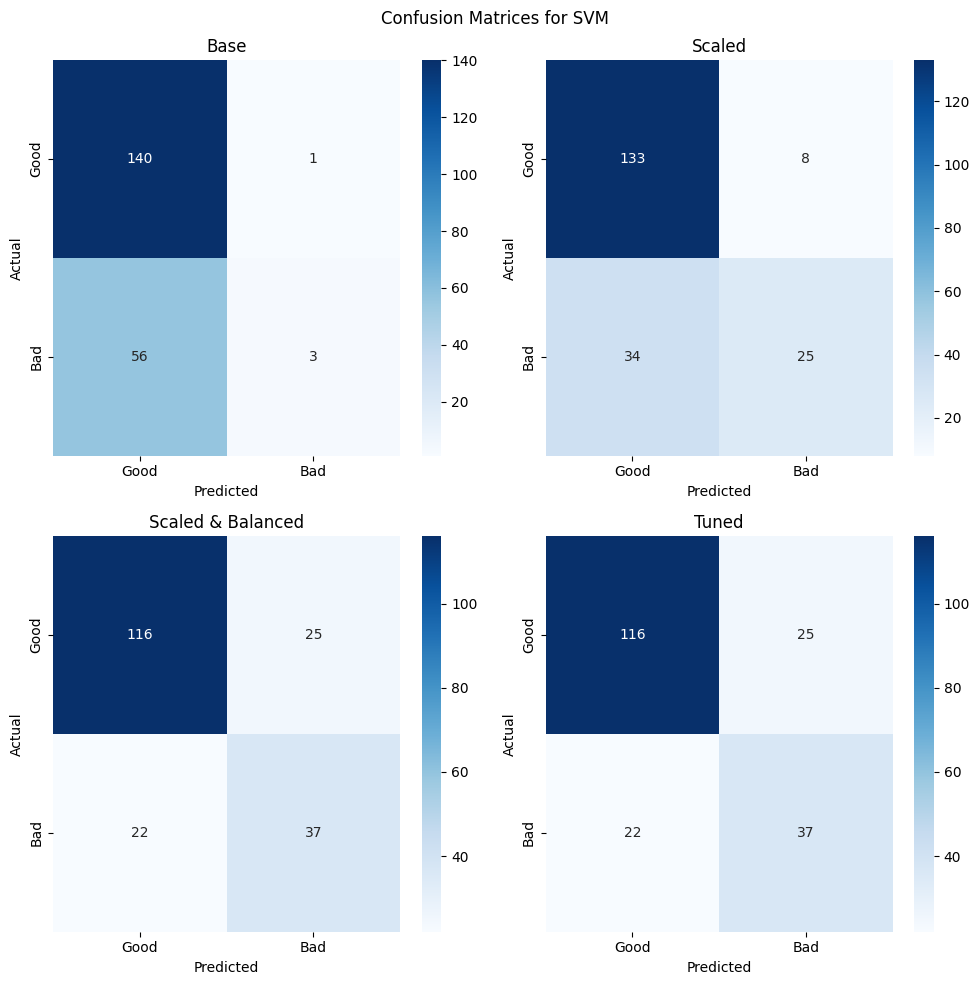

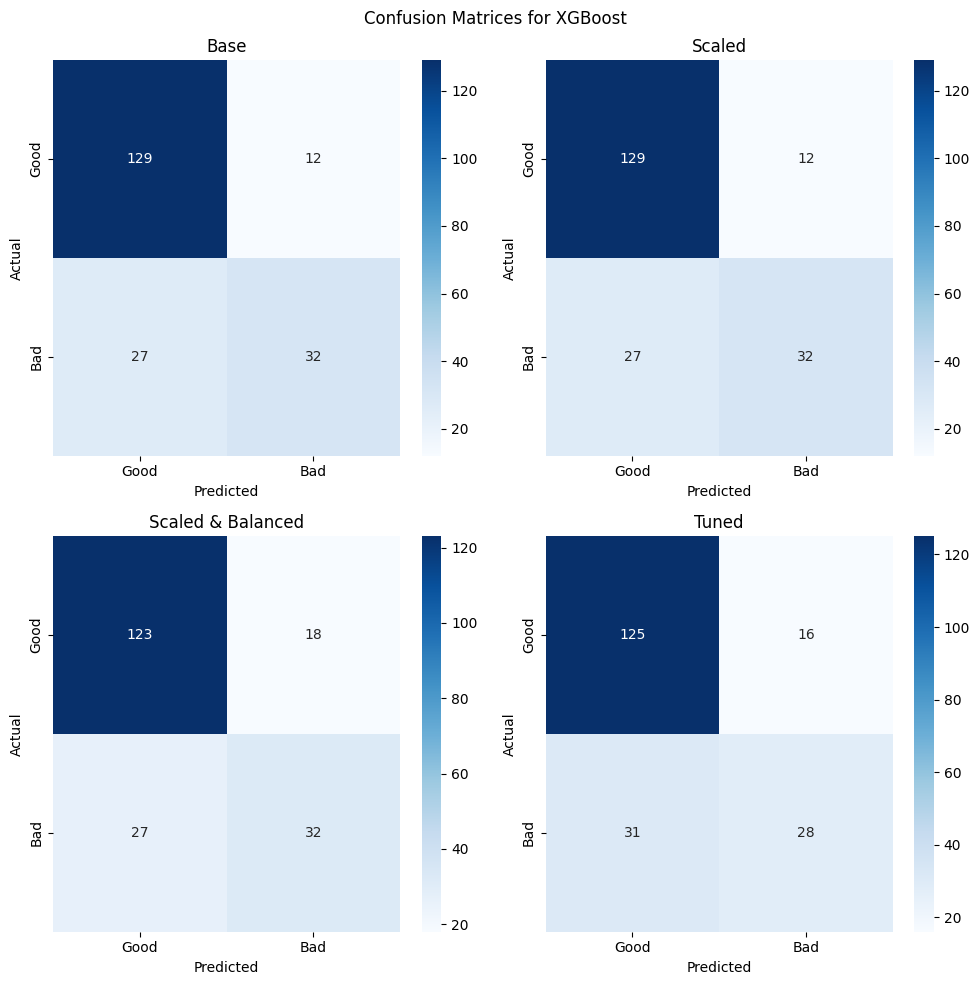



Base Models:



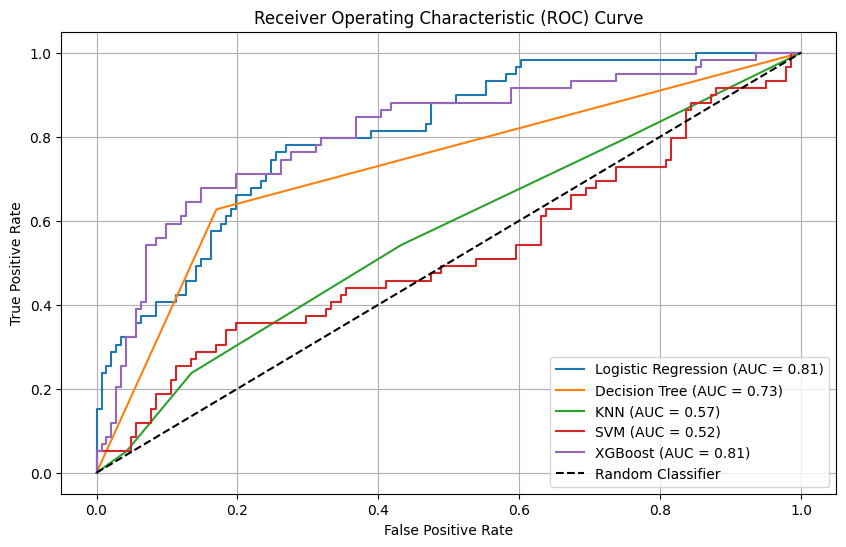



Number Scaled Models:



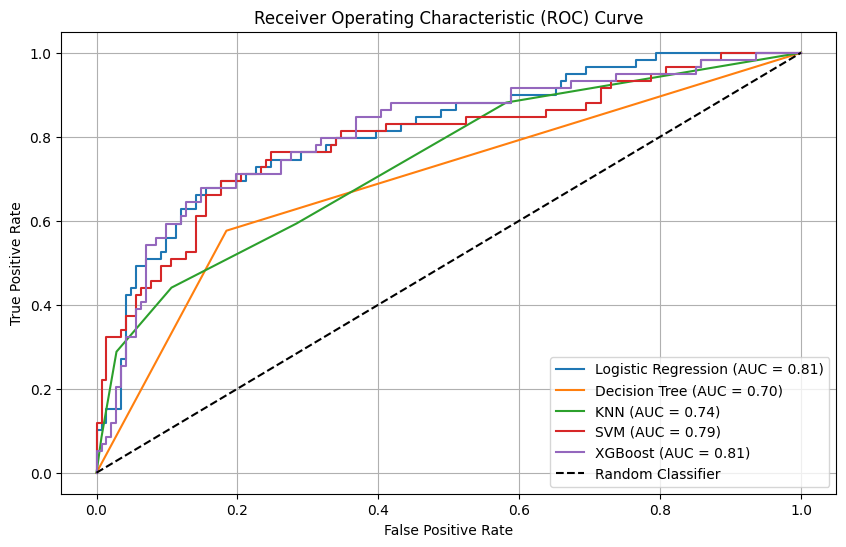



Number Scaled Balanced Models:



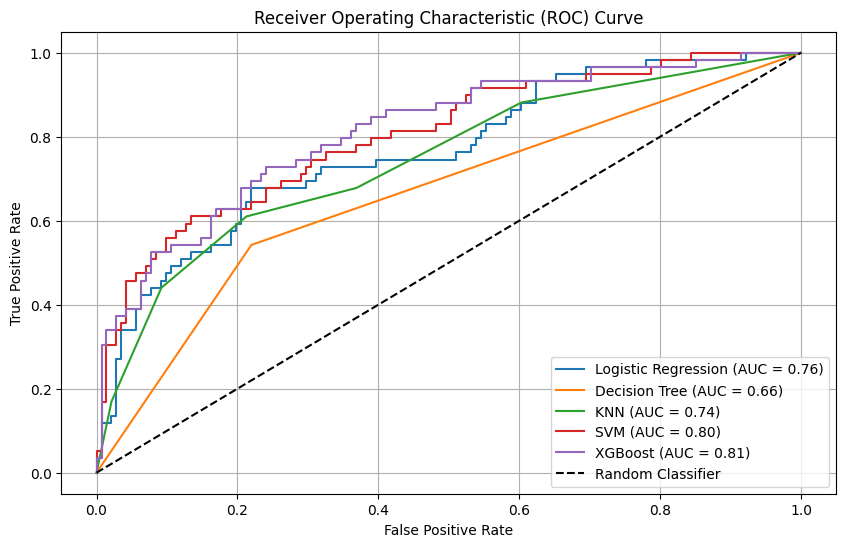



Number Scaled Balanced Tuned Models:



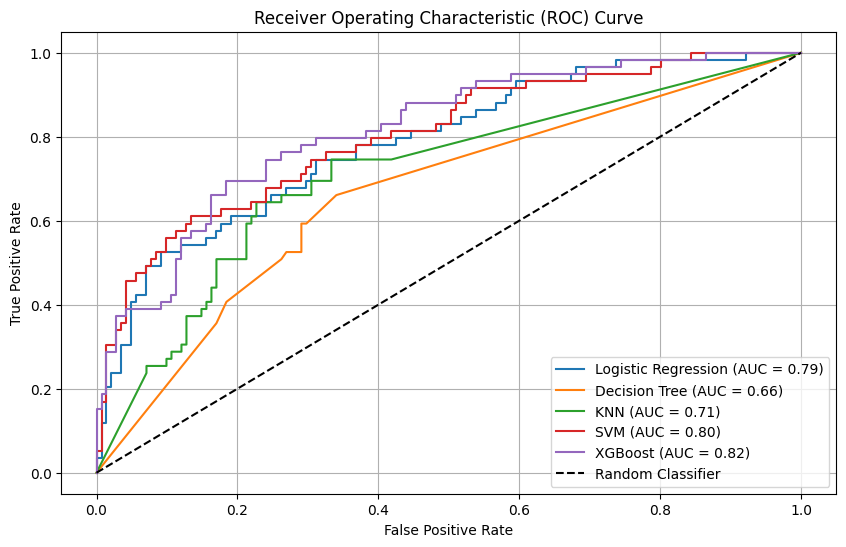

In [90]:
# evaluate classification models
model_comp_pipeline(features_train, features_test, target_train, target_test)

## **Feature Importance Applied**

This block executes _feature_importance_pipeline()_

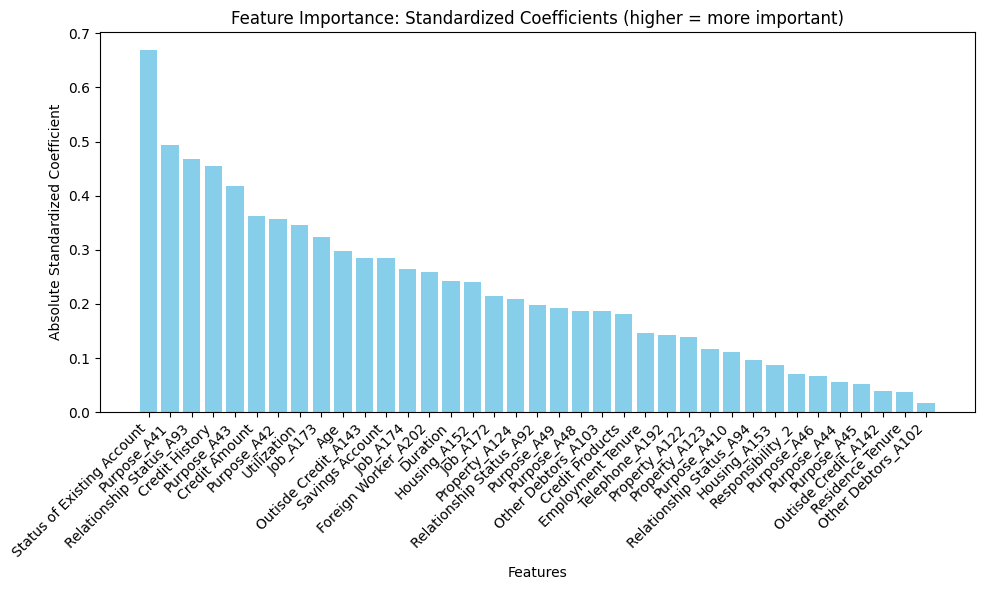

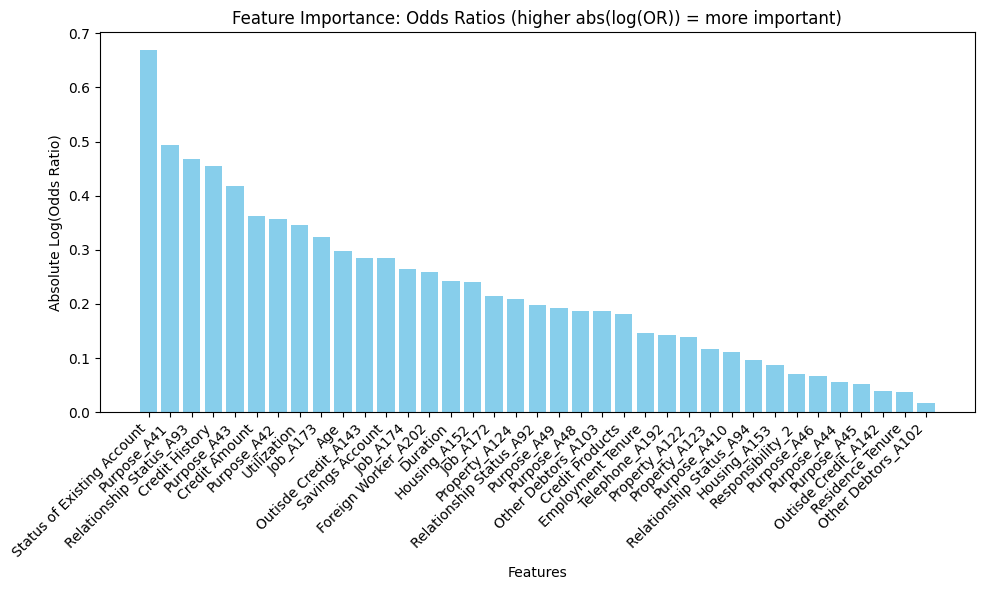

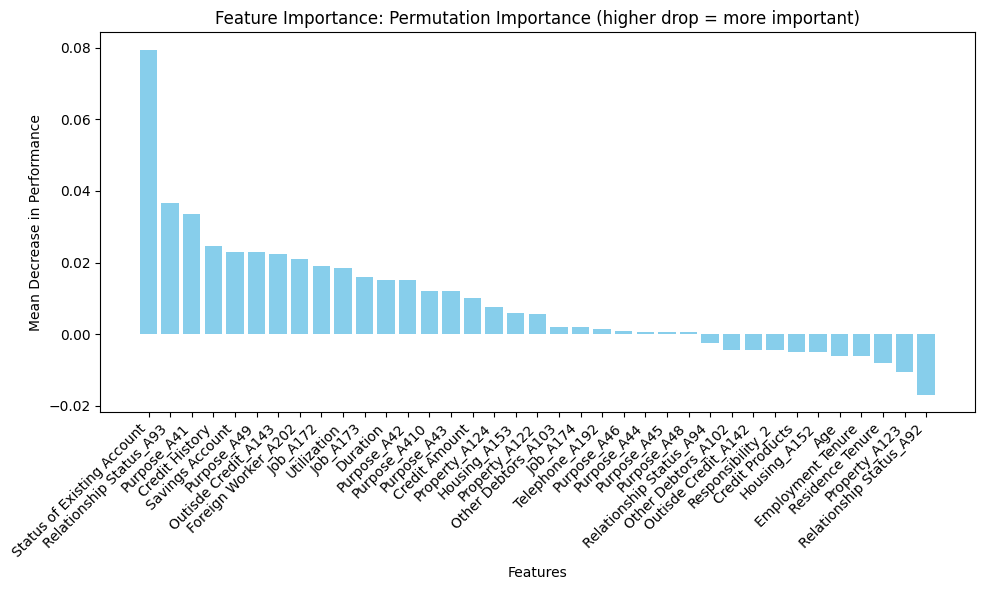

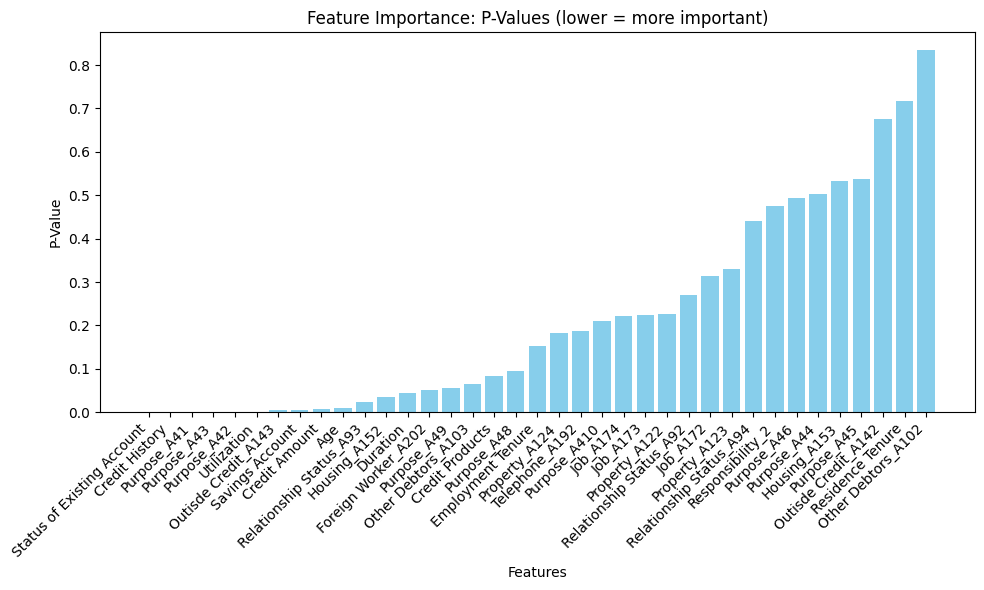

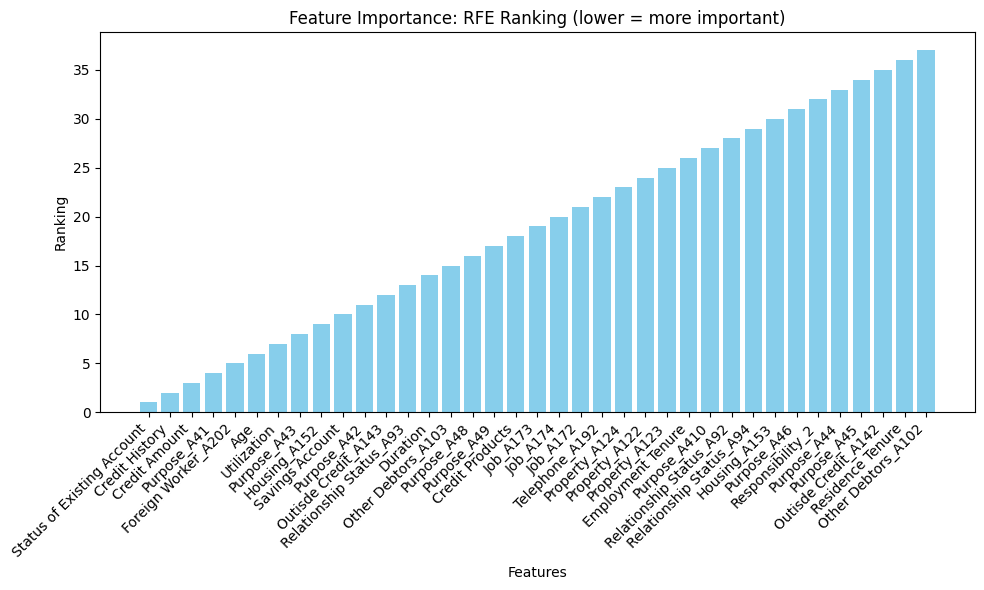


=== Evaluating Feature Selection with standardized_coefficients ===
Selected Features (standardized_coefficients): ['Status of Existing Account', 'Purpose_A41', 'Relationship Status_A93', 'Credit History', 'Purpose_A43', 'Credit Amount', 'Purpose_A42', 'Utilization', 'Job_A173', 'Age']

=== Evaluating Feature Selection with odds_ratios ===
Selected Features (odds_ratios): ['Status of Existing Account', 'Purpose_A41', 'Relationship Status_A93', 'Credit History', 'Purpose_A43', 'Credit Amount', 'Purpose_A42', 'Utilization', 'Job_A173', 'Age']

=== Evaluating Feature Selection with permutation_importance ===
Selected Features (permutation_importance): ['Status of Existing Account', 'Relationship Status_A93', 'Purpose_A41', 'Credit History', 'Savings Account', 'Purpose_A49', 'Outisde Credit_A143', 'Foreign Worker_A202', 'Job_A172', 'Utilization']

=== Evaluating Feature Selection with p_values ===
Selected Features (p_values): ['Status of Existing Account', 'Credit History', 'Purpose_A41'

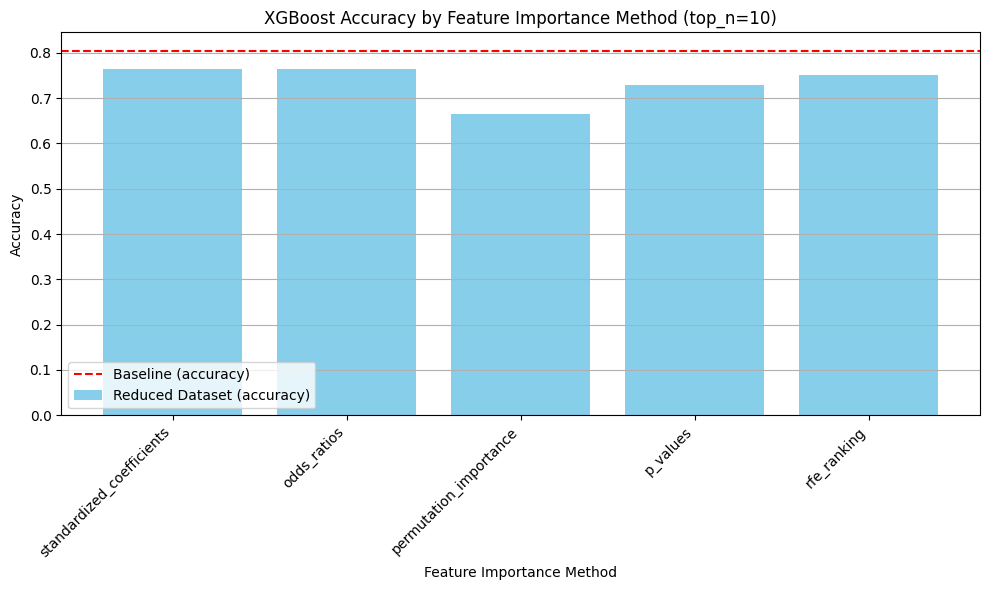

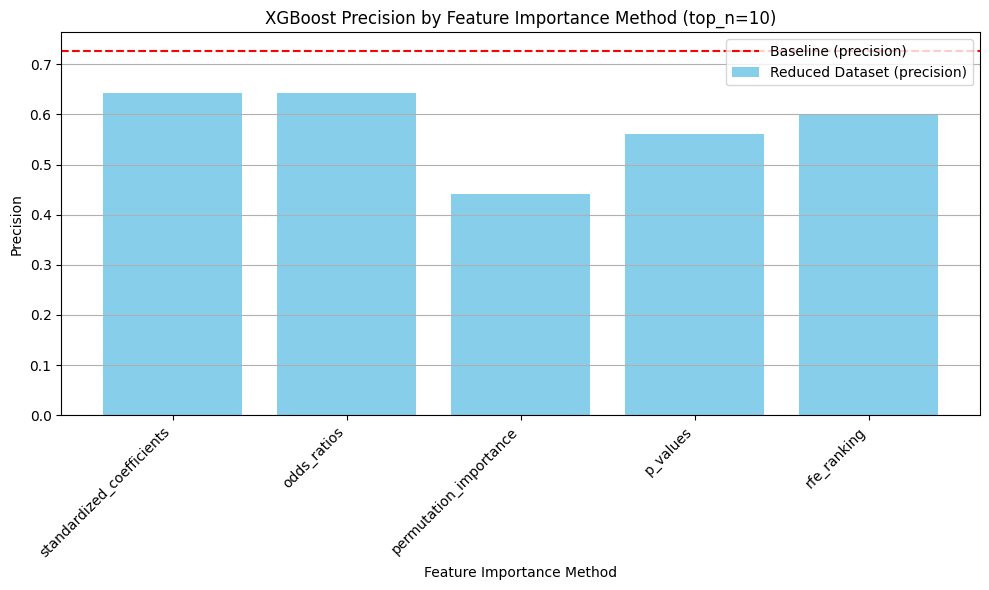

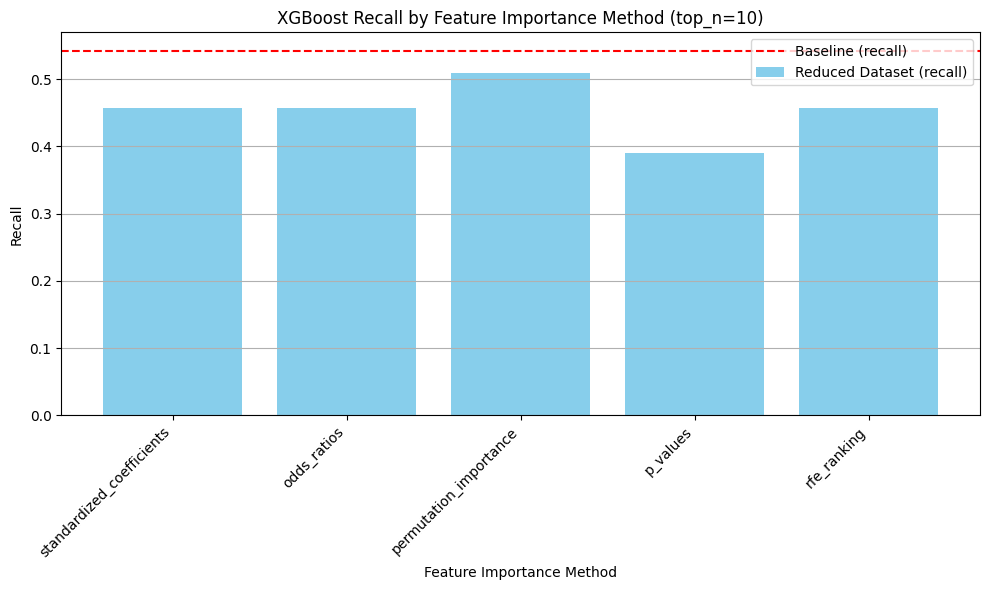

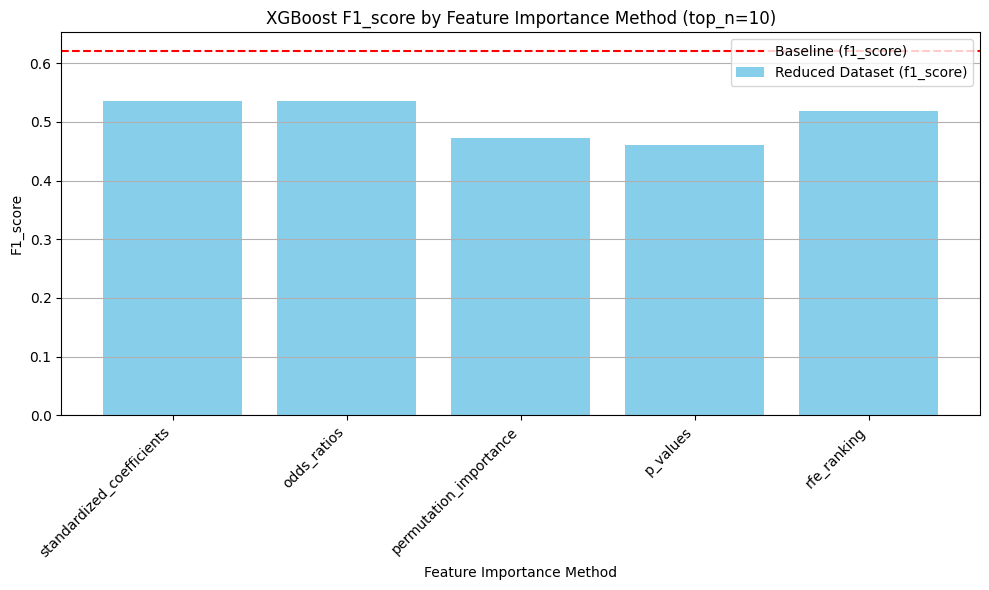

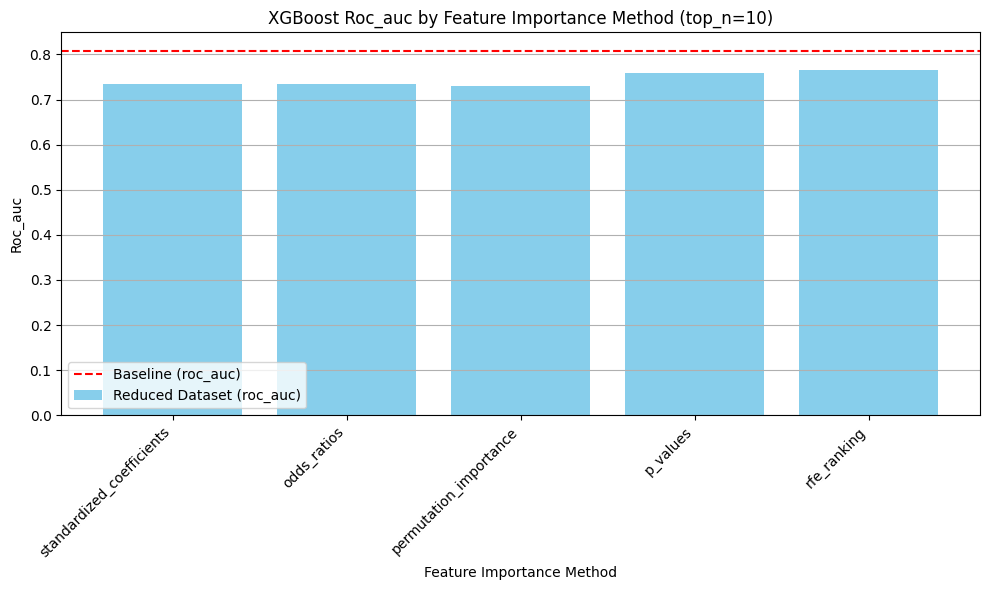

In [102]:
# Feature Importance
feature_importance_pipeline(features_train, features_test, target_train, target_test)